In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/Shareddrives/QAC211_Project

ls: cannot access 'drive/Shareddrives/QAC211_Project': No such file or directory


In [ ]:
import requests
import pandas as pd

In [ ]:
api_key = "REDACTED"

meta = requests.get(
    "https://api.census.gov/data/2022/acs/acs5/variables.json"
).json()

state_resp = requests.get(
    "https://api.census.gov/data/2022/acs/acs5?get=NAME&for=state:*&key=REDACTED"
).json()

state_list = [row[1] for row in state_resp[1:]]

records = []
for st in state_list:
    url = (
        f"https://api.census.gov/data/2022/acs/acs5?get=B19013_001E,NAME&for=tract:*&in=state:{st}&in=county:*&key=REDACTED"
    )
    data = requests.get(url).json()
    df = pd.DataFrame(data[1:], columns=data[0])
    df["state"] = st
    records.append(df)

all_tracts = pd.concat(records, ignore_index=True)

In [ ]:
all_tracts.head()

,B19013_001E,NAME,state,county,tract
0,60563,Census Tract 201; Autauga County; Alabama,01,001,020100
1,57460,Census Tract 202; Autauga County; Alabama,01,001,020200
2,77371,Census Tract 203; Autauga County; Alabama,01,001,020300
3,73191,Census Tract 204; Autauga County; Alabama,01,001,020400
4,79953,Census Tract 205.01; Autauga County; Alabama,01,001,020501


In [ ]:
import geopandas as gpd
# read the tracts polygon file
gdf = gpd.read_file("/content/drive/Shareddrives/QAC239_Project/tracts/cb_2022_us_tract_500k.zip")


In [ ]:
gdf_proj = gdf.to_crs(epsg=5070)

gdf_proj["centroid"] = gdf_proj.geometry.centroid

cent = gdf_proj.centroid.to_crs(epsg=4326)
gdf["lat"] = cent.y
gdf["lng"] = cent.x

In [ ]:
gdf.head()

,STATEFP,COUNTYFP,TRACTCE,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,NAMELSADCO,STATE_NAME,LSAD,ALAND,AWATER,geometry,lat,lng
0,06,077,005127,1400000US06077005127,06077005127,51.27,Census Tract 51.27,CA,San Joaquin County,California,CT,1960015,0,"POLYGON ((-121.28708 37.83381, -121.28499 37.8...",37.834034,-121.281085
1,06,077,003406,1400000US06077003406,06077003406,34.06,Census Tract 34.06,CA,San Joaquin County,California,CT,839414,14789,"POLYGON ((-121.309 38.02824, -121.30461 38.028...",38.024770,-121.300998
2,06,077,004402,1400000US06077004402,06077004402,44.02,Census Tract 44.02,CA,San Joaquin County,California,CT,4346363,0,"POLYGON ((-121.27338 38.10811, -121.27286 38.1...",38.108652,-121.258070
3,06,077,001700,1400000US06077001700,06077001700,17,Census Tract 17,CA,San Joaquin County,California,CT,1685934,0,"POLYGON ((-121.26642 37.9753, -121.26453 37.97...",37.977436,-121.257392
4,06,077,000401,1400000US06077000401,06077000401,4.01,Census Tract 4.01,CA,San Joaquin County,California,CT,1045658,0,"POLYGON ((-121.31334 37.96416, -121.30553 37.9...",37.961342,-121.305801


In [ ]:
#
# all_tracts["GEOID"] = all_tracts["GEOID"].astype(str)
# gdf["GEOID"] = gdf["GEOID"].astype(str)

#
# gdf = gdf.merge(all_tracts[["GEOID","median_income"]], on="GEOID", how="left")

#
# gdf["income_bin"] = pd.qcut(
#     gdf["median_income"].astype(float),
#     q=3,
#     labels=["low","medium","high"]
# )

KeyError: 'GEOID'

In [ ]:

income_df = all_tracts.rename(columns={"B19013_001E": "median_income"})
income_df["GEOID"] = (
  income_df.state.str.zfill(2)
  + income_df.county.str.zfill(3)
  + income_df.tract.str.zfill(6)
)
income_df["median_income"] = income_df["median_income"].astype(float)


gdf["GEOID"] = gdf["GEOID"].astype(str)

gdf = gdf.merge(
    income_df[["GEOID", "median_income"]],
    on="GEOID",
    how="left"
)

print(gdf[["GEOID", "median_income"]].head())



         GEOID  median_income
0  06077005127       102440.0
1  06077003406        38497.0
2  06077004402        89167.0
3  06077001700        51083.0
4  06077000401        57500.0


In [ ]:
gdf = gdf.dropna(subset=["median_income"])

gdf["income_bin"] = pd.qcut(
    gdf["median_income"],
    q=3,
    labels=["low", "medium", "high"]
)

print(gdf["income_bin"].value_counts())

print(gdf.geometry.name)

output_path = "/content/drive/Shareddrives/QAC239_Project/data/satellite/tracts_with_income.geojson"
gdf.to_file(output_path, driver="GeoJSON")
print("Saved →", output_path)
gdf.to_file(
  "/content/drive/Shareddrives/QAC239_Project/data/satellite/tracts_with_income.geojson",
  driver="GeoJSON"
)

In [ ]:

try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_prefix = "/content/drive/Shareddrives/QAC239_Project"
except ModuleNotFoundError:
    base_prefix = "."


import requests, os

API_KEY = "REDACTED"
BASE_META = "https://maps.googleapis.com/maps/api/streetview/metadata"
BASE_IMG  = "https://maps.googleapis.com/maps/api/streetview"

import time

gdf_path = os.path.join(base_prefix, "data/tracts_with_income.geojson")
data_dir = os.path.join(base_prefix, "data")
progress_file = os.path.join(base_prefix, "progress.txt")


for lbl in ("low","medium","high"):
    os.makedirs(os.path.join(data_dir, lbl), exist_ok=True)

gdf = gpd.read_file(gdf_path)

if os.path.exists(progress_file):
    with open(progress_file, "r") as f:
        content = f.read().strip()
    try:
        start_idx = int(content)
    except ValueError:
        print(f"Warning: couldn’t parse progress (‘{content}’); starting at 0")
        start_idx = 0
else:
    start_idx = 0

print(f"Starting at tract #{start_idx} / {len(gdf)}")

META_URL = "https://maps.googleapis.com/maps/api/streetview/metadata"
IMG_URL  = "https://maps.googleapis.com/maps/api/streetview"

for i, row in enumerate(gdf.itertuples(), start=0):
    if i < start_idx:
        continue

    geoid, lat, lng, label = row.GEOID, row.lat, row.lng, row.income_bin
    print(f"[{i}] {geoid}({label}) @{lat:.6f},{lng:.6f}", end=" ... ")

    img_resp = requests.get(IMG_URL, params={
        "size": "640x640",
        "location": f"{lat},{lng}",
        "key": API_KEY
    })

    if img_resp.status_code != 200:
        print(f"Img error {img_resp.status_code}")
        with open(progress_file, "w") as f:
            f.write(str(i+1))
        continue

    out_path = os.path.join(data_dir, label, f"{geoid}.jpg")
    with open(out_path, "wb") as f:
        f.write(img_resp.content)
    print(f"Saved → {out_path}")

    with open(progress_file, "w") as f:
        f.write(str(i+1))

    time.sleep(0.1)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
"""
Re-binning downloaded pics using 20-60-20 split
"""
import pandas as pd
import geopandas as gpd
import os
import shutil

old_img_dir = "/content/drive/Shareddrives/QAC239_Project/satellite"
new_img_dir = "/content/drive/Shareddrives/QAC239_Project/satellite_20_20_split"

gdf = gpd.read_file("/content/drive/Shareddrives/QAC239_Project/data/tracts_with_income.geojson")

gdf = gdf.dropna(subset=["median_income"])

gdf["old_bin"] = gdf["income_bin"]


gdf["income_bin"] = pd.qcut(
    gdf["median_income"],
    q=[0, 0.2, 0.8, 1.0],
    labels=["low", "medium", "high"]
)

In [ ]:
"""
this cell actually copies the files. DON'T run unless you need to for some reason
"""
for row in gdf.itertuples():
    geoid = row.GEOID
    old_folder = os.path.join(old_img_dir, row.old_bin)
    new_folder = os.path.join(new_img_dir, row.income_bin)
    src_path = os.path.join(old_folder, f"{geoid}.jpg")
    dst_path = os.path.join(new_folder, f"{geoid}.jpg")

    if os.path.exists(src_path):
        shutil.copy2(src_path, dst_path)
    else:
        print(f"Warning: missing {src_path}")

Streaming output truncated to the last 5000 lines.


In [ ]:
# write out only GEOID and its 20-60-20 bin
gdf[["GEOID", "income_bin"]] \
   .to_csv(
       "/content/drive/Shareddrives/QAC239_Project/geoid_to_20_60_20_bin.csv",
       index=False
   )


In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    base_prefix = "/content/drive/Shareddrives/QAC211_Project"
except ModuleNotFoundError:
    base_prefix = "."



import requests, os, time, geopandas as gpd

API_KEY = "REDACTED"
STATIC_URL = "https://maps.googleapis.com/maps/api/staticmap"

ZOOM   = 16
SIZE   = "640x640"
SCALE  = 1

gdf_path      = os.path.join(base_prefix, "data/satellite/tracts_with_income.geojson")
data_dir      = os.path.join(base_prefix, "data/satellite")
progress_file = os.path.join(base_prefix, "progress.txt")

for lbl in ("low", "medium", "high"):
    os.makedirs(os.path.join(data_dir, lbl), exist_ok=True)

gdf = gpd.read_file(gdf_path)

if os.path.exists(progress_file):
    try:
        start_idx = int(open(progress_file).read().strip())
    except ValueError:
        start_idx = 0
else:
    start_idx = 0

print(f"Starting at tract #{start_idx} / {len(gdf)}")

for i, row in enumerate(gdf.itertuples(), start=0):
    if i < start_idx:
        continue

    geoid, lat, lon, label = row.GEOID, row.lat, row.lng, row.income_bin
    print(f"[{i}] {geoid} ({label}) @ {lat:.6f},{lon:.6f} … ", end="")

    params = {
        "center": f"{lat},{lon}",
        "zoom": ZOOM,
        "size": SIZE,
        "scale": SCALE,
        "maptype": "satellite",
        "key": API_KEY,
    }

    resp = requests.get(STATIC_URL, params=params, timeout=20)

    if resp.status_code != 200:
        print(f"error {resp.status_code}")
        open(progress_file, "w").write(str(i + 1))
        continue

    out_path = os.path.join(data_dir, label, f"{geoid}.jpg")
    with open(out_path, "wb") as f:
        f.write(resp.content)
    print("saved")


    open(progress_file, "w").write(str(i + 1))
    time.sleep(0.1)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Starting at tract #21667 / 85059
[21667] 11001005602 (high) @ 38.899288,-77.054308 … saved
[21668] 11001003701 (high) @ 38.921459,-77.034302 … saved
[21669] 06071009719 (medium) @ 34.443551,-117.222694 … saved
[21670] 06071008405 (high) @ 34.070270,-117.166218 … saved
[21671] 06017030604 (low) @ 38.947852,-120.724442 … saved
[21672] 09110490304 (high) @ 41.655196,-72.695648 … saved
[21673] 06039000901 (low) @ 36.967095,-120.045020 … saved
[21674] 47065011206 (medium) @ 35.091451,-85.039848 … saved
[21675] 72045952000 (low) @ 18.218625,-66.223114 … saved
[21676] 39095002500 (low) @ 41.658275,-83.575770 … saved
[21677] 39095004900 (low) @ 41.637617,-83.510478 … saved
[21678] 39095005901 (medium) @ 41.724770,-83.614773 … saved
[21679] 22033003603 (low) @ 30.464645,-91.064858 … saved
[21680] 26125162300 (medium) @ 42.450687,-83.225254 … saved
[21681] 01089000301 

In [ ]:
gdf_path

'/content/drive/Shareddrives/QAC211_Project/data/tracts_with_income.geojson'

Installing scikit-learn …
Loading dataset from /content/drive/Shareddrives/QAC239_Project/street_20_20_split
Capped to ≤500 per class → 1500 total imgs


<ipython-input-7-36d1887817cc>:159: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler     = GradScaler()
<ipython-input-7-36d1887817cc>:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(imgs); loss = criterion(logits, lbls)
<ipython-input-7-36d1887817cc>:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(imgs); loss = criterion(logits, lbls)


Epoch 01/25 | train 1.1480/0.343 | val 1.1143/0.343 | 14.3s


<ipython-input-7-36d1887817cc>:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(imgs); loss = criterion(logits, lbls)
<ipython-input-7-36d1887817cc>:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(imgs); loss = criterion(logits, lbls)


Epoch 02/25 | train 1.1126/0.382 | val 1.1095/0.363 | 15.0s


<ipython-input-7-36d1887817cc>:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(imgs); loss = criterion(logits, lbls)
<ipython-input-7-36d1887817cc>:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(imgs); loss = criterion(logits, lbls)


Epoch 03/25 | train 1.0837/0.405 | val 1.1253/0.353 | 11.7s
Epoch 04/25 | train 1.0988/0.407 | val 1.1221/0.353 | 12.5s
Epoch 05/25 | train 1.0860/0.419 | val 1.0999/0.360 | 12.2s
Epoch 06/25 | train 1.0482/0.435 | val 1.1390/0.343 | 12.5s
Epoch 07/25 | train 1.0453/0.445 | val 1.1299/0.383 | 12.2s


<ipython-input-7-36d1887817cc>:175: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(imgs); loss = criterion(logits, lbls)
<ipython-input-7-36d1887817cc>:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(imgs); loss = criterion(logits, lbls)


Epoch 08/25 | train 1.0455/0.450 | val 1.1014/0.383 | 12.7s
Epoch 09/25 | train 1.0401/0.468 | val 1.1123/0.383 | 12.1s
Epoch 10/25 | train 1.0563/0.453 | val 1.1673/0.350 | 12.2s
Epoch 11/25 | train 1.0516/0.439 | val 1.1049/0.360 | 11.9s
Epoch 12/25 | train 1.0264/0.461 | val 1.1072/0.367 | 11.4s
Early stopping — no improvement for 5 epochs


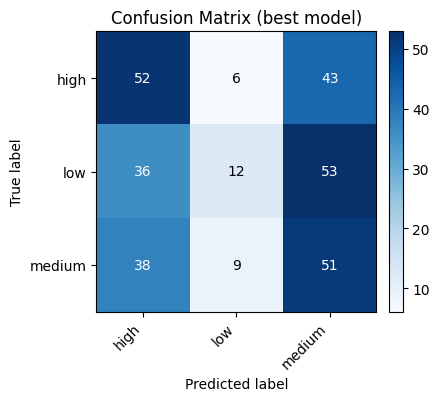

<Figure size 640x480 with 0 Axes>

In [ ]:
# Single Directory Training

import sys, subprocess, importlib.util, os, random, math, time
from pathlib import Path

_REQ_PKGS = ["timm", "torchmetrics", "scikit-learn", "matplotlib"]

def _ensure_packages():
    for pkg in _REQ_PKGS:
        if importlib.util.find_spec(pkg) is None:
            print(f"Installing {pkg} …")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

def _mount_drive():
    try:
        import google.colab
        from google.colab import drive
        if not os.path.isdir("/content/drive"):
            drive.mount("/content/drive")
    except ImportError:
        pass

_ensure_packages()
_mount_drive()

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from collections import Counter
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


data_root       = Path("/content/drive/Shareddrives/QAC239_Project/street_20_20_split")
ckpt_dir        = Path("/content/drive/MyDrive/ses_level_ckpts"); ckpt_dir.mkdir(parents=True, exist_ok=True)

num_classes     = 3
cap_per_class   = 500
batch_size      = 32
epochs          = 25
base_lr         = 1e-3
seed            = 42

random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])
val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])


print("Loading dataset from", data_root)
full_ds = ImageFolder(data_root)

if cap_per_class is not None:
    cls_to_idxs = {c: [] for c in range(num_classes)}
    for idx, lbl in enumerate(full_ds.targets):
        cls_to_idxs[lbl].append(idx)
    rng = torch.Generator().manual_seed(seed)
    capped = []
    for cls, idxs in cls_to_idxs.items():
        if not idxs:
            continue
        perm = torch.tensor(idxs)[torch.randperm(len(idxs), generator=rng)]
        capped.extend(perm[: min(len(idxs), cap_per_class)].tolist())
    full_ds = Subset(full_ds, capped)
    print(f"Capped to ≤{cap_per_class} per class → {len(full_ds)} total imgs")

train_len = int(0.8 * len(full_ds)); val_len = len(full_ds) - train_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len], generator=torch.Generator().manual_seed(seed))

class TfmDS(torch.utils.data.Dataset):
    def __init__(self, subset, tfm):
        self.subset, self.tfm = subset, tfm
    def __len__(self): return len(self.subset)
    def __getitem__(self, idx):
        x, y = self.subset[idx]; return self.tfm(x), y

train_ds, val_ds = TfmDS(train_ds, train_tfms), TfmDS(val_ds, val_tfms)

counts = Counter([lbl for _, lbl in train_ds])
cls_wts = torch.tensor([1.0 / counts.get(i, 1) for i in range(num_classes)], device=device)

nworkers = min(4, os.cpu_count() or 2)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=nworkers, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=nworkers, pin_memory=True)


model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

for p in model.parameters(): p.requires_grad = False
for p in model.fc.parameters(): p.requires_grad = True

criterion  = nn.CrossEntropyLoss(weight=cls_wts)
optimizer  = torch.optim.AdamW(model.parameters(), lr=base_lr)
scheduler  = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
scaler     = GradScaler()


patience, best_acc, bad_epochs = 5, 0.0, 0
cm_best = None

for epoch in range(1, epochs + 1):
    t0 = time.time()
    model.train(); tr_loss = tr_hits = 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        with autocast(): logits = model(imgs); loss = criterion(logits, lbls)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        tr_loss += loss.item() * imgs.size(0)
        tr_hits += (logits.argmax(1) == lbls).sum().item()
    scheduler.step()
    tr_loss /= len(train_loader.dataset); tr_acc = tr_hits / len(train_loader.dataset)

    model.eval(); val_loss = 0; preds, labels = [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            with autocast(): logits = model(imgs); loss = criterion(logits, lbls)
            val_loss += loss.item() * imgs.size(0)
            preds.append(logits.argmax(1).cpu()); labels.append(lbls.cpu())
    val_loss /= len(val_loader.dataset)
    preds, labels = torch.cat(preds), torch.cat(labels)
    val_acc = (preds == labels).float().mean().item()

    print(f"Epoch {epoch:02d}/{epochs} | train {tr_loss:.4f}/{tr_acc:.3f} | val {val_loss:.4f}/{val_acc:.3f} | {time.time()-t0:.1f}s")

    if val_acc > best_acc:
        best_acc, bad_epochs = val_acc, 0
        cm_best = confusion_matrix(labels, preds, labels=list(range(num_classes)))
        torch.save(model.state_dict(), ckpt_dir / "best_resnet18.pth")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping — no improvement for", patience, "epochs")
            break

cm = cm_best if cm_best is not None else confusion_matrix(labels, preds, labels=list(range(num_classes)))
class_names = full_ds.dataset.classes if isinstance(full_ds, Subset) else full_ds.classes

fig, ax = plt.subplots(figsize=(4.5,4.5))
im = ax.imshow(cm, cmap="Blues")

ax.set_xlabel("Predicted label"); ax.set_ylabel("True label")
ax.set_xticks(range(num_classes)); ax.set_yticks(range(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha="right"); ax.set_yticklabels(class_names)

for i in range(num_classes):
    for j in range(num_classes):
        txt_color = "white" if cm[i,j] > cm.max()/2 else "black"
        ax.text(j, i, cm[i,j], ha="center", va="center", color=txt_color)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.title("Confusion Matrix (best model)")
plt.tight_layout()
plt.show()
plt.savefig("Satellite2020.png")



Installing scikit-learn …
Loading datasets:
 • /content/drive/Shareddrives/QAC239_Project/street_20_20_split
 • /content/drive/Shareddrives/QAC239_Project/satellite_20_20_split
Merged dataset → 20285 images across 3 classes: ['high', 'low', 'medium']
Capped to ≤500 per class → 1500 total images


<ipython-input-8-84122e5a2c88>:194: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()
<ipython-input-8-84122e5a2c88>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-84122e5a2c88>:227: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 01/25 | train 1.1514/0.347 | val 1.1187/0.350 | 79.8s


<ipython-input-8-84122e5a2c88>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-84122e5a2c88>:227: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 02/25 | train 1.1191/0.372 | val 1.1040/0.417 | 13.3s


<ipython-input-8-84122e5a2c88>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-84122e5a2c88>:227: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 03/25 | train 1.0906/0.420 | val 1.0865/0.420 | 13.2s


<ipython-input-8-84122e5a2c88>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-84122e5a2c88>:227: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 04/25 | train 1.0947/0.412 | val 1.0899/0.427 | 14.5s


<ipython-input-8-84122e5a2c88>:210: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
<ipython-input-8-84122e5a2c88>:227: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 05/25 | train 1.0686/0.428 | val 1.0836/0.410 | 12.9s
Epoch 06/25 | train 1.0502/0.438 | val 1.1038/0.347 | 12.6s
Epoch 07/25 | train 1.0441/0.483 | val 1.0999/0.427 | 12.0s
Epoch 08/25 | train 1.0469/0.448 | val 1.0775/0.393 | 12.9s
Epoch 09/25 | train 1.0347/0.467 | val 1.0956/0.387 | 12.6s
Early stopping — no improvement for 5 epochs

Classification report (best model):

              precision    recall  f1-score   support

        high      0.542     0.317     0.400       101
         low      0.336     0.475     0.393       101
      medium      0.367     0.367     0.367        98

    accuracy                          0.387       300
   macro avg      0.415     0.386     0.387       300
weighted avg      0.416     0.387     0.387       300



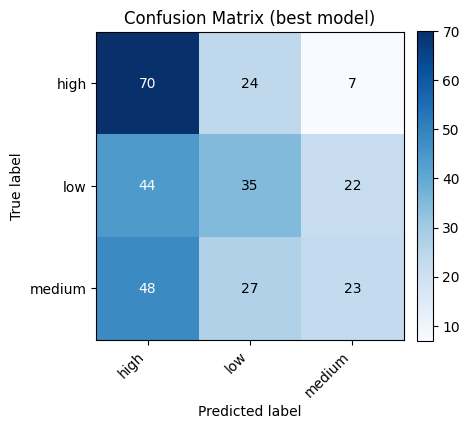

Saved confusion matrix plot → /content/drive/MyDrive/ses_level_ckpts/confusion_matrix.png


In [ ]:
#"Early Fusion", Simple Mixing of Satellite and Streetview


import sys, subprocess, importlib.util, os, random, time
from pathlib import Path

_REQ_PKGS = ["timm", "torchmetrics", "scikit-learn", "matplotlib"]

def _ensure_packages():
    for pkg in _REQ_PKGS:
        if importlib.util.find_spec(pkg) is None:
            print(f"Installing {pkg} …")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])

def _mount_drive():
    try:
        import google.colab
        from google.colab import drive
        if not os.path.isdir("/content/drive"):
            drive.mount("/content/drive")
    except ImportError:
        pass

_ensure_packages()
_mount_drive()


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from collections import Counter
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt



DATA_DIRS = [
    Path("/content/drive/Shareddrives/QAC239_Project/street_20_20_split"),
    Path("/content/drive/Shareddrives/QAC239_Project/satellite_20_20_split"),
]
CKPT_DIR       = Path("/content/drive/MyDrive/ses_level_ckpts"); CKPT_DIR.mkdir(parents=True, exist_ok=True)
NUM_CLASSES    = 3
CAP_PER_CLASS  = 500
BATCH_SIZE     = 32
EPOCHS         = 25
BASE_LR        = 1e-3
SEED           = 42
PATIENCE       = 5

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])
val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])


print("Loading datasets:")
for p in DATA_DIRS:
    print(" •", p)

parts = [ImageFolder(p) for p in DATA_DIRS]

base_classes = parts[0].classes
for ds in parts[1:]:
    if ds.classes != base_classes:
        raise ValueError("Class folders mismatch across DATA_DIRS")

full_ds = ConcatDataset(parts)
print(f"Merged dataset → {len(full_ds)} images across {NUM_CLASSES} classes: {base_classes}")

if CAP_PER_CLASS is not None:
    cls_to_idxs = {c: [] for c in range(NUM_CLASSES)}
    offset = 0
    for ds in parts:
        for i, lbl in enumerate(ds.targets):
            cls_to_idxs[lbl].append(offset + i)
        offset += len(ds)
    rng = torch.Generator().manual_seed(SEED)
    capped = []
    for cls, idxs in cls_to_idxs.items():
        if not idxs:
            continue
        perm = torch.tensor(idxs)[torch.randperm(len(idxs), generator=rng)]
        capped.extend(perm[: min(len(idxs), CAP_PER_CLASS)].tolist())
    full_ds = Subset(full_ds, capped)
    print(f"Capped to ≤{CAP_PER_CLASS} per class → {len(full_ds)} total images")


train_len = int(0.8 * len(full_ds))
val_len   = len(full_ds) - train_len
train_ds, val_ds = random_split(full_ds, [train_len, val_len], generator=torch.Generator().manual_seed(SEED))

class TfmDS(torch.utils.data.Dataset):
    def __init__(self, subset, tfm):
        self.subset, self.tfm = subset, tfm
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        return self.tfm(x), y

train_ds, val_ds = TfmDS(train_ds, train_tfms), TfmDS(val_ds, val_tfms)


counts = Counter([lbl for _, lbl in train_ds])
cls_wts = torch.tensor([1.0 / counts.get(i, 1) for i in range(NUM_CLASSES)], device=device)

nworkers = min(4, os.cpu_count() or 2)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=nworkers,
                          pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=nworkers,
                          pin_memory=True)

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
model.to(device)

for p in model.parameters():
    p.requires_grad = False
for p in model.fc.parameters():
    p.requires_grad = True

criterion = nn.CrossEntropyLoss(weight=cls_wts)
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler    = GradScaler()

best_acc, bad_epochs = 0.0, 0
cm_best = None

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    model.train(); tr_loss = tr_hits = 0
    for imgs, lbls in train_loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        with autocast():
            logits = model(imgs)
            loss = criterion(logits, lbls)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        tr_loss += loss.item() * imgs.size(0)
        tr_hits += (logits.argmax(1) == lbls).sum().item()
    scheduler.step()
    tr_loss /= len(train_loader.dataset)
    tr_acc = tr_hits / len(train_loader.dataset)

    model.eval(); val_loss = 0; preds, labels = [], []
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            with autocast():
                logits = model(imgs)
                loss = criterion(logits, lbls)
            val_loss += loss.item() * imgs.size(0)
            preds.append(logits.argmax(1).cpu())
            labels.append(lbls.cpu())
    val_loss /= len(val_loader.dataset)
    preds, labels = torch.cat(preds), torch.cat(labels)
    val_acc = (preds == labels).float().mean().item()

    elapsed = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | train {tr_loss:.4f}/{tr_acc:.3f} | val {val_loss:.4f}/{val_acc:.3f} | {elapsed:.1f}s")

    if val_acc > best_acc:
        best_acc, bad_epochs = val_acc, 0
        cm_best = confusion_matrix(labels, preds, labels=list(range(NUM_CLASSES)))
        torch.save(model.state_dict(), CKPT_DIR / "best_resnet18.pth")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("Early stopping — no improvement for", PATIENCE, "epochs")
            break


cm = cm_best if cm_best is not None else confusion_matrix(labels, preds, labels=list(range(NUM_CLASSES)))
print("\nClassification report (best model):\n")
print(classification_report(labels, preds, target_names=base_classes, digits=3))

fig, ax = plt.subplots(figsize=(4.8, 4.8))
im = ax.imshow(cm, cmap="Blues")

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks(range(NUM_CLASSES))
ax.set_yticks(range(NUM_CLASSES))
ax.set_xticklabels(base_classes, rotation=45, ha="right")
ax.set_yticklabels(base_classes)


for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        txt_color = "white" if cm[i, j] > cm.max() / 2 else "black"
        ax.text(j, i, cm[i, j], ha="center", va="center", color=txt_color)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.title("Confusion Matrix (best model)")
plt.tight_layout()

png_path = CKPT_DIR / "confusion_matrix.png"
plt.savefig(png_path, dpi=150)
plt.show()
print(f"Saved confusion matrix plot → {png_path}")


Installing scikit-learn…
Loading datasets…
  • /content/drive/Shareddrives/QAC239_Project/street_20_20_split: 14011 samples, classes=['high', 'low', 'medium']
  • /content/drive/Shareddrives/QAC239_Project/satellite_20_20_split: 4371 samples, classes=['high', 'low', 'medium']
  • Using 1500 from /content/drive/Shareddrives/QAC239_Project/street_20_20_split after cap=500
  • Using 1500 from /content/drive/Shareddrives/QAC239_Project/satellite_20_20_split after cap=500
Total samples: 1500

Starting training…



<ipython-input-10-8a01ed461302>:189: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()
<ipython-input-10-8a01ed461302>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
<ipython-input-10-8a01ed461302>:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)


Epoch 1/25 | tr_loss=1.1734 tr_acc=0.384 | val_loss=1.4246 val_acc=0.367 | 28.7s


<ipython-input-10-8a01ed461302>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
<ipython-input-10-8a01ed461302>:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)


Epoch 2/25 | tr_loss=1.0865 tr_acc=0.392 | val_loss=1.0348 val_acc=0.447 | 29.7s


<ipython-input-10-8a01ed461302>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
<ipython-input-10-8a01ed461302>:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)


Epoch 3/25 | tr_loss=1.0744 tr_acc=0.421 | val_loss=1.1147 val_acc=0.407 | 29.2s
Epoch 4/25 | tr_loss=1.0379 tr_acc=0.453 | val_loss=1.1453 val_acc=0.420 | 28.5s
Epoch 5/25 | tr_loss=1.0568 tr_acc=0.442 | val_loss=1.0906 val_acc=0.413 | 27.1s
Epoch 6/25 | tr_loss=1.0246 tr_acc=0.457 | val_loss=1.0319 val_acc=0.433 | 27.0s
Epoch 7/25 | tr_loss=1.0052 tr_acc=0.470 | val_loss=1.0051 val_acc=0.477 | 26.9s


<ipython-input-10-8a01ed461302>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
<ipython-input-10-8a01ed461302>:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)


Epoch 8/25 | tr_loss=0.9936 tr_acc=0.487 | val_loss=1.0689 val_acc=0.463 | 29.3s
Epoch 9/25 | tr_loss=0.9943 tr_acc=0.477 | val_loss=1.0054 val_acc=0.520 | 27.1s


<ipython-input-10-8a01ed461302>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
<ipython-input-10-8a01ed461302>:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)


Epoch 10/25 | tr_loss=0.9935 tr_acc=0.482 | val_loss=0.9177 val_acc=0.567 | 29.1s


<ipython-input-10-8a01ed461302>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
<ipython-input-10-8a01ed461302>:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)


Epoch 11/25 | tr_loss=0.9811 tr_acc=0.502 | val_loss=1.2640 val_acc=0.447 | 29.2s
Epoch 12/25 | tr_loss=0.9575 tr_acc=0.514 | val_loss=1.0423 val_acc=0.500 | 26.9s
Epoch 13/25 | tr_loss=0.9722 tr_acc=0.508 | val_loss=0.8885 val_acc=0.577 | 28.7s


<ipython-input-10-8a01ed461302>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
<ipython-input-10-8a01ed461302>:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)


Epoch 14/25 | tr_loss=0.9681 tr_acc=0.516 | val_loss=0.9154 val_acc=0.570 | 30.0s
Epoch 15/25 | tr_loss=0.9505 tr_acc=0.536 | val_loss=0.8499 val_acc=0.607 | 26.9s


<ipython-input-10-8a01ed461302>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
<ipython-input-10-8a01ed461302>:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)


Epoch 16/25 | tr_loss=0.9158 tr_acc=0.552 | val_loss=0.8954 val_acc=0.583 | 29.3s
Epoch 17/25 | tr_loss=0.9123 tr_acc=0.551 | val_loss=0.8659 val_acc=0.587 | 27.2s
Epoch 18/25 | tr_loss=0.8997 tr_acc=0.557 | val_loss=0.7902 val_acc=0.633 | 27.8s


<ipython-input-10-8a01ed461302>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
<ipython-input-10-8a01ed461302>:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)


Epoch 19/25 | tr_loss=0.8821 tr_acc=0.557 | val_loss=0.8914 val_acc=0.590 | 29.5s
Epoch 20/25 | tr_loss=0.8773 tr_acc=0.578 | val_loss=0.7563 val_acc=0.667 | 27.2s


<ipython-input-10-8a01ed461302>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
<ipython-input-10-8a01ed461302>:216: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)


Epoch 21/25 | tr_loss=0.8849 tr_acc=0.571 | val_loss=0.7730 val_acc=0.637 | 30.5s
Epoch 22/25 | tr_loss=0.8547 tr_acc=0.588 | val_loss=0.7391 val_acc=0.647 | 27.4s
Epoch 23/25 | tr_loss=0.8250 tr_acc=0.593 | val_loss=0.7226 val_acc=0.650 | 27.1s
Epoch 24/25 | tr_loss=0.8528 tr_acc=0.583 | val_loss=0.7150 val_acc=0.663 | 26.8s
Epoch 25/25 | tr_loss=0.8379 tr_acc=0.600 | val_loss=0.7149 val_acc=0.643 | 26.9s
Early stopping after 5 epochs without improvement.
              precision    recall  f1-score   support

        high      0.728     0.822     0.772       101
         low      0.648     0.782     0.709       101
      medium      0.484     0.316     0.383        98

    accuracy                          0.643       300
   macro avg      0.620     0.640     0.621       300
weighted avg      0.621     0.643     0.623       300

Saved confusion matrix to /content/drive/MyDrive/ses_level_ckpts/confusion_matrix.png


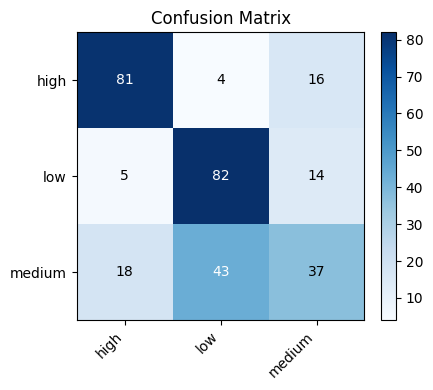

In [ ]:
# Late Fusion

import sys, subprocess, importlib.util, os, random, time
from pathlib import Path

_REQ_PKGS = ["timm", "torchmetrics", "scikit-learn", "matplotlib"]

def _ensure_packages():
    for pkg in _REQ_PKGS:
        if importlib.util.find_spec(pkg) is None:
            print(f"Installing {pkg}…")
            subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"]);

def _mount_drive():
    try:
        import google.colab
        from google.colab import drive
        if not os.path.isdir("/content/drive"):
            drive.mount("/content/drive")
    except ImportError:
        pass

_ensure_packages()
_mount_drive()

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Subset, Dataset
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from collections import Counter, defaultdict
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt


DATA_DIRS   = [
    Path("/content/drive/Shareddrives/QAC239_Project/street_20_20_split"),
    Path("/content/drive/Shareddrives/QAC239_Project/satellite_20_20_split"),
]
LATE_FUSION = True
CKPT_DIR    = Path("/content/drive/MyDrive/ses_level_ckpts"); CKPT_DIR.mkdir(exist_ok=True, parents=True)
NUM_CLASSES   = 3
CAP_PER_CLASS = 500
BATCH_SIZE    = 32
EPOCHS        = 25
BASE_LR       = 1e-3
SEED          = 42
PATIENCE      = 5

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), transforms.Normalize(imagenet_mean, imagenet_std)
])
val_tfms = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(), transforms.Normalize(imagenet_mean, imagenet_std)
])


def cap_dataset(ds: ImageFolder, cap: int, seed: int):
    if cap is None:
        return ds
    cls_to_idxs = defaultdict(list)
    for idx, (_, y) in enumerate(ds.samples):
        cls_to_idxs[y].append(idx)
    keep = []
    g = torch.Generator().manual_seed(seed)
    for c, idxs in cls_to_idxs.items():
        perm = torch.tensor(idxs)[torch.randperm(len(idxs), generator=g)]
        keep.extend(perm[:min(len(idxs), cap)].tolist())
    return Subset(ds, keep)


print("Loading datasets…")
raw = [ImageFolder(p) for p in DATA_DIRS]
for p, ds in zip(DATA_DIRS, raw):
    print(f"  • {p}: {len(ds)} samples, classes={ds.classes}")
parts = [cap_dataset(ds, CAP_PER_CLASS, SEED) for ds in raw]
for p, ds in zip(DATA_DIRS, parts):
    print(f"  • Using {len(ds)} from {p} after cap={CAP_PER_CLASS}")

class PairDataset(Dataset):
    def __init__(self, a: Dataset, b: Dataset, seed: int=0):
        self.a, self.b = a, b; self.rng = random.Random(seed)
        self.map = defaultdict(list)
        for i, (_, y) in enumerate(a): self.map[y].append(i)
        self.map_b = defaultdict(list)
        for i, (_, y) in enumerate(b): self.map_b[y].append(i)
        if set(self.map)!=set(self.map_b): raise ValueError("Class mismatch")
    def __len__(self): return sum(len(v) for v in self.map.values())
    def __getitem__(self, idx):
        running=0
        for c, idxs in self.map.items():
            if idx < running+len(idxs):
                a_i = idxs[idx-running]
                b_i = self.rng.choice(self.map_b[c])
                xa, _ = self.a[a_i]; xb, _ = self.b[b_i]
                return xa, xb, c
            running+=len(idxs)
        raise IndexError

full = PairDataset(parts[0], parts[1], seed=SEED) if LATE_FUSION else parts[0]
print(f"Total samples: {len(full)}")


train_n = int(0.8*len(full)); val_n = len(full)-train_n
train_raw, val_raw = random_split(full, [train_n, val_n], generator=torch.Generator().manual_seed(SEED))
class WrapSingle(Dataset):
    def __init__(self, ds, tfm): self.ds, self.tfm = ds, tfm
    def __len__(self): return len(self.ds)
    def __getitem__(self,i): x,y=self.ds[i]; return self.tfm(x),y
class WrapPair(Dataset):
    def __init__(self, ds, tfm): self.ds, self.tfm = ds, tfm
    def __len__(self): return len(self.ds)
    def __getitem__(self,i): xa,xb,y=self.ds[i]; return self.tfm(xa),self.tfm(xb),y
train_ds = WrapPair(train_raw, train_tfms) if LATE_FUSION else WrapSingle(train_raw, train_tfms)
val_ds   = WrapPair(val_raw,   val_tfms)    if LATE_FUSION else WrapSingle(val_raw,   val_tfms)


counts = Counter([y if not LATE_FUSION else item[2] for item in train_ds])
weights = torch.tensor([1.0/counts[i] for i in range(NUM_CLASSES)], device=device)
nw = min(4, os.cpu_count() or 1)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=nw, pin_memory=True, persistent_workers=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=nw, pin_memory=True)


if LATE_FUSION:
    class DualResNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.a = models.resnet18(weights=models.ResNet18_Weights.DEFAULT); self.a.fc=nn.Identity()
            self.b = models.resnet18(weights=models.ResNet18_Weights.DEFAULT); self.b.fc=nn.Identity()
            self.head = nn.Sequential(nn.Linear(512*2,256),nn.ReLU(),nn.Dropout(0.2),nn.Linear(256,NUM_CLASSES))
        def forward(self, xa, xb): return self.head(torch.cat([self.a(xa), self.b(xb)], dim=1))
    model = DualResNet().to(device)
else:
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT); model.fc=nn.Linear(model.fc.in_features, NUM_CLASSES); model=model.to(device)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=BASE_LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler    = GradScaler()


best_acc=0; bad=0; cm_best=None
print("\nStarting training…\n")
for epoch in range(1, EPOCHS+1):
    st=time.time()
    model.train(); train_loss=train_correct=0
    for batch in train_loader:
        optimizer.zero_grad()
        if LATE_FUSION: xa,xb,y = batch; xa,xb,y = xa.to(device), xb.to(device), y.to(device)
        else: x,y = batch; x,y = x.to(device), y.to(device)
        with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
        loss = criterion(logits.float(), y)
        scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        train_loss += loss.item()*y.size(0)
        train_correct += (logits.argmax(1)==y).sum().item()
    scheduler.step()
    train_loss/= len(train_loader.dataset); train_acc=train_correct/len(train_loader.dataset)
    # validation
    model.eval(); val_loss=val_correct=0; preds=[]; trues=[]
    with torch.no_grad():
        for batch in val_loader:
            if LATE_FUSION: xa,xb,y = batch; xa,xb,y = xa.to(device), xb.to(device), y.to(device)
            else: x,y = batch; x,y = x.to(device), y.to(device)
            with autocast(): logits = model(xa, xb) if LATE_FUSION else model(x)
            loss = criterion(logits.float(), y)
            val_loss += loss.item()*y.size(0)
            val_correct += (logits.argmax(1)==y).sum().item()
            preds.append(logits.argmax(1).cpu()); trues.append(y.cpu())
    val_loss/=len(val_loader.dataset); val_acc=val_correct/len(val_loader.dataset)
    print(f"Epoch {epoch}/{EPOCHS} | tr_loss={train_loss:.4f} tr_acc={train_acc:.3f} | val_loss={val_loss:.4f} val_acc={val_acc:.3f} | {time.time()-st:.1f}s")
    # early stop
    trues_all=torch.cat(trues); preds_all=torch.cat(preds)
    if val_acc>best_acc:
        best_acc=val_acc; bad=0
        cm_best=confusion_matrix(trues_all, preds_all, labels=list(range(NUM_CLASSES)))
        torch.save(model.state_dict(), CKPT_DIR/"best_model.pth")
    else:
        bad+=1
        if bad>=PATIENCE:
            print(f"Early stopping after {PATIENCE} epochs without improvement.")
            break


print(classification_report(trues_all, preds_all, target_names=classes, digits=3))
cm=cm_best if cm_best is not None else confusion_matrix(trues_all, preds_all, labels=list(range(NUM_CLASSES)))
classes = raw[0].classes
fig, ax = plt.subplots(figsize=(5,4))
im = ax.imshow(cm, cmap='Blues')
ax.set_xticks(range(NUM_CLASSES)); ax.set_xticklabels(classes, rotation=45, ha='right')
ax.set_yticks(range(NUM_CLASSES)); ax.set_yticklabels(classes)
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        color='white' if cm[i,j]>cm.max()/2 else 'black'
        ax.text(j, i, cm[i,j], ha='center', va='center', color=color)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.title('Confusion Matrix')
plt.tight_layout()
save_path = CKPT_DIR/"confusion_matrix.png"
plt.savefig(save_path)
print(f"Saved confusion matrix to {save_path}")
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
